In [1]:
import tensorflow as tf
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
import math as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
sigma_z_prior = 1
pi = np.pi

In [3]:
def generate_data(N, alpha, sigma_reward):
    '''
    alpha az y tengellyel bezart szog fokokban merve
    '''
    z_ = tfd.Sample(
    tfd.Independent(
      tfd.Normal(loc=[0, 0], scale=[sigma_z_prior, sigma_z_prior])))
    z = z_.sample(N)

    gamma_0 = np.array([np.cos(alpha/180*pi), np.sin(alpha/180*pi)])
    r = np.zeros(N)
    for i in range(N):
        r_ = tfd.Sample(
          tfd.Independent(
              tfd.Normal(loc = gamma_0[0]*z[i, 0] + gamma_0[1]*z[i, 1], scale=sigma_reward)))
        r[i] = r_.sample(1)

    return z, r

In [ ]:
def monte_carlo_test(f_is_simple, p, num_samples_list, dataset_size , num_of_trials, sigma_reward, alpha):
    N = dataset_size
    if f_is_simple:
    def f_simple(gamma):
        #A = 1/(sigma_reward*np.sqrt(2*pi))
        #B = -1/2*sigma_reward**2
        exponents = np.zeros(num_samples)
        for i in range(num_samples):
        exponents[i] = tf.reduce_sum((gamma[i]*z[:, 0] - r)**2)
        #return (A**N)*np.exp(exponents)
        return np.exp(-exponents)
    else:
    def f_difficult(gamma):
        #A = 1/(sigma_reward*np.sqrt(2*pi))
        #B = -1/2*sigma_reward**2
        exponents = np.zeros(num_samples)
        for i in range(num_samples):
        exponents[i] = tf.reduce_sum((tf.linalg.matmul(tf.expand_dims(gamma[i, :], 0), tf.transpose(z)) - r)**2)
        #return (A**N)*np.exp(exponents)
        return np.exp(-exponents)

    output = np.zeros((num_of_trials, num_samples_list.shape[0]))
    z, r = generate_data(N = N, alpha = alpha, sigma_reward = sigma_reward)

    for j, num_samples in enumerate(num_samples_list): 
    if f_is_simple:
        for i in range(num_of_trials):
            likelihood = tfp.monte_carlo.expectation(
            f=f_simple,
            samples=p.sample(num_samples, seed=4223432))
            output[i, j] = likelihood
    else:
        for i in range(num_of_trials):
            likelihood = tfp.monte_carlo.expectation(
            f=f_difficult,
            samples=p.sample(num_samples, seed=4223432))
            output[i, j] = likelihood
    print(num_samples)

    return output

In [ ]:
f_is_simple = False
p = tfd.Normal(loc=[0, 0], scale=[1, 1])
dataset_size = 150
num_of_trials = 30
num_samples_list = np.arange(500, 35000, 3000)
sigma_reward = .3
alpha = 20
output = monte_carlo_test(f_is_simple, p, num_samples_list, dataset_size , num_of_trials, sigma_reward, alpha)

500
3500
6500
9500
12500
15500
18500
21500
24500
27500
30500
33500


In [ ]:
def plot_variance(output, num_samples_list):
    plt.figure(figsize = (10, 8))
    var_list = np.var(output, axis = 0)
    x = np.arange(var_list.shape[0])
    plt.plot(x, var_list)
    plt.xlabel('Number of samples')
    plt.ylabel('Variance')
    plt.xticks(labels = num_samples_list, ticks = x)
    plt.grid()
    plt.show()

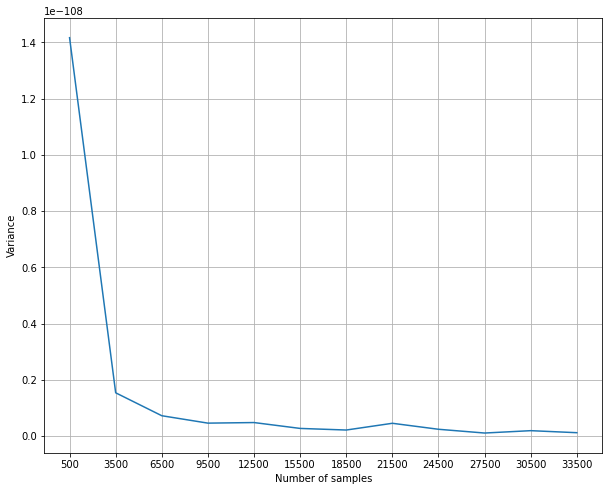

In [ ]:
plot_variance(output, num_samples_list)

Ennél  a beállításnál ~27000 minta elég. Itt még nem voltak kivéve a szorzófaktorok az átlagolandó függvényekből.

In [ ]:
f_is_simple = False
p = tfd.Normal(loc=[0, 0], scale=[1, 1])
dataset_size = 150
num_of_trials = 30
num_samples_list = np.arange(500, 35000, 3000)
sigma_reward = .01
alpha = 20
output = monte_carlo_test(f_is_simple, p, num_samples_list, dataset_size, num_of_trials, sigma_reward, alpha)

500
3500
6500
9500
12500
15500
18500
21500
24500
27500
30500
33500


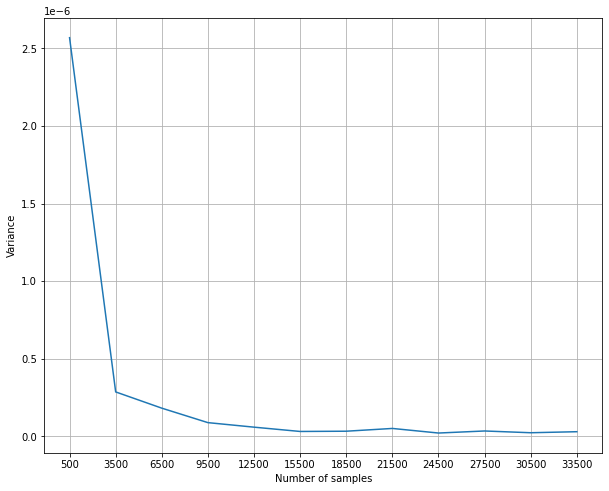

In [ ]:
plot_variance(output, num_samples_list)

27000 mintapont elég lesz.

In [4]:
def f_simple(gamma):
    '''
    y axis-aligned modell feltetelezese mellett ezt a fuggvenyt kell a gamma prior felett atlagolni
    '''
    num_points = z.shape[0]
    exponents = np.zeros(num_samples)
    for i in range(num_samples):
        exponents[i] = tf.reduce_sum((gamma[i]*z[:, 0] - r)**2)
    return .9**(num_points)*np.exp(-exponents)

In [6]:
def f_difficult(gamma):
    '''
    non axis-aligned modell feltetelezese mellett ezt a fuggvenyt kell a gamma prior felett atlagolni
    '''
    num_points = z.shape[0]
    exponents = np.zeros(num_samples)
    for i in range(num_samples):
        exponents[i] = tf.reduce_sum((tf.linalg.matmul(tf.expand_dims(gamma[i, :], 0), tf.transpose(z)) - r)**2)
    return .9**(num_points)*np.exp(-exponents)

In [13]:
Ns = np.concatenate((np.arange(1, 15), np.arange(15, 46, 3), np.arange(46, 150, 7)))

sigma_rewards = np.array([.000012, .0012, .01, .3]).astype('float32')

alphas_000012 = np.arange(10, 41, 5)
alphas_001200 = np.arange(10, 51, 10)
alphas_010000 = np.arange(10, 61, 10)
alphas_300000 = np.arange(12, 65, 10)

#teszthez:
#Ns = np.arange(1, 3)
#sigma_rewards = np.array([.1, .2]).astype('float32')
#alphas_1 = np.array([30])
#alphas_2 = np.array([30])

num_samples = 27000


p = tfd.Normal(loc=0, scale=1)
p2 = tfd.Normal(loc=[0, 0], scale=[1, 1])
for i in range(sigma_rewards.shape[0]):
    l = Ns.shape[0]
    number = format(sigma_rewards[i], 'f')
    exec('m = alphas_%s.shape[0]'%number.replace('0.', ''))

    exec('output_simple_%s = np.zeros((m, l))'%number.replace('0.', ''))
    exec('output_difficult_%s = np.zeros((m, l))'%number.replace('0.', ''))

for sigma_reward in sigma_rewards:
    number = format(sigma_reward, 'f')
    exec('alphas = alphas_%s'%number.replace('0.', ''))
    for j, alpha in enumerate(alphas):
        for  k, N in enumerate(Ns):
            z, r = generate_data(N = N, alpha= alpha, sigma_reward = sigma_reward)

            exec('simple = output_simple_%s'%number.replace('0.', ''))
            exec('difficult = output_difficult_%s'%number.replace('0.', ''))

            simple[j, k] = tfp.monte_carlo.expectation(
            f=f_simple,
            samples=p.sample(num_samples, seed=4222))
            difficult[j, k] = tfp.monte_carlo.expectation(
            f=f_difficult,
            samples=p2.sample(num_samples, seed=4222))
            print('sigma: %f\n'%sigma_reward)
            print('alpha: %f\n'%alpha)
            print('N: %d\n'%N)
            np.save('output_difficult_%s.npy'%number.replace('0.', ''), difficult)
            np.save('output_simple_%s.npy'%number.replace('0.', ''), simple)

sigma: 0.000012

alpha: 10.000000

N: 1

sigma: 0.000012

alpha: 10.000000

N: 2

sigma: 0.000012

alpha: 10.000000

N: 3

sigma: 0.000012

alpha: 10.000000

N: 4

sigma: 0.000012

alpha: 10.000000

N: 5

sigma: 0.000012

alpha: 10.000000

N: 6

sigma: 0.000012

alpha: 10.000000

N: 7

sigma: 0.000012

alpha: 10.000000

N: 8

sigma: 0.000012

alpha: 10.000000

N: 9

sigma: 0.000012

alpha: 10.000000

N: 10

sigma: 0.000012

alpha: 10.000000

N: 11

sigma: 0.000012

alpha: 10.000000

N: 12

sigma: 0.000012

alpha: 10.000000

N: 13

sigma: 0.000012

alpha: 10.000000

N: 14

sigma: 0.000012

alpha: 10.000000

N: 15

sigma: 0.000012

alpha: 10.000000

N: 18

sigma: 0.000012

alpha: 10.000000

N: 21

sigma: 0.000012

alpha: 10.000000

N: 24

sigma: 0.000012

alpha: 10.000000

N: 27

sigma: 0.000012

alpha: 10.000000

N: 30

sigma: 0.000012

alpha: 10.000000

N: 33

sigma: 0.000012

alpha: 10.000000

N: 36

sigma: 0.000012

alpha: 10.000000

N: 39

sigma: 0.000012

alpha: 10.000000

N: 42

s

sigma: 0.000012

alpha: 30.000000

N: 123

sigma: 0.000012

alpha: 30.000000

N: 130

sigma: 0.000012

alpha: 30.000000

N: 137

sigma: 0.000012

alpha: 30.000000

N: 144

sigma: 0.000012

alpha: 35.000000

N: 1

sigma: 0.000012

alpha: 35.000000

N: 2

sigma: 0.000012

alpha: 35.000000

N: 3

sigma: 0.000012

alpha: 35.000000

N: 4

sigma: 0.000012

alpha: 35.000000

N: 5

sigma: 0.000012

alpha: 35.000000

N: 6

sigma: 0.000012

alpha: 35.000000

N: 7

sigma: 0.000012

alpha: 35.000000

N: 8

sigma: 0.000012

alpha: 35.000000

N: 9

sigma: 0.000012

alpha: 35.000000

N: 10

sigma: 0.000012

alpha: 35.000000

N: 11

sigma: 0.000012

alpha: 35.000000

N: 12

sigma: 0.000012

alpha: 35.000000

N: 13

sigma: 0.000012

alpha: 35.000000

N: 14

sigma: 0.000012

alpha: 35.000000

N: 15

sigma: 0.000012

alpha: 35.000000

N: 18

sigma: 0.000012

alpha: 35.000000

N: 21

sigma: 0.000012

alpha: 35.000000

N: 24

sigma: 0.000012

alpha: 35.000000

N: 27

sigma: 0.000012

alpha: 35.000000

N: 3

sigma: 0.001200

alpha: 30.000000

N: 95

sigma: 0.001200

alpha: 30.000000

N: 102

sigma: 0.001200

alpha: 30.000000

N: 109

sigma: 0.001200

alpha: 30.000000

N: 116

sigma: 0.001200

alpha: 30.000000

N: 123

sigma: 0.001200

alpha: 30.000000

N: 130

sigma: 0.001200

alpha: 30.000000

N: 137

sigma: 0.001200

alpha: 30.000000

N: 144

sigma: 0.001200

alpha: 40.000000

N: 1

sigma: 0.001200

alpha: 40.000000

N: 2

sigma: 0.001200

alpha: 40.000000

N: 3

sigma: 0.001200

alpha: 40.000000

N: 4

sigma: 0.001200

alpha: 40.000000

N: 5

sigma: 0.001200

alpha: 40.000000

N: 6

sigma: 0.001200

alpha: 40.000000

N: 7

sigma: 0.001200

alpha: 40.000000

N: 8

sigma: 0.001200

alpha: 40.000000

N: 9

sigma: 0.001200

alpha: 40.000000

N: 10

sigma: 0.001200

alpha: 40.000000

N: 11

sigma: 0.001200

alpha: 40.000000

N: 12

sigma: 0.001200

alpha: 40.000000

N: 13

sigma: 0.001200

alpha: 40.000000

N: 14

sigma: 0.001200

alpha: 40.000000

N: 15

sigma: 0.001200

alpha: 40.000000

N

sigma: 0.010000

alpha: 30.000000

N: 67

sigma: 0.010000

alpha: 30.000000

N: 74

sigma: 0.010000

alpha: 30.000000

N: 81

sigma: 0.010000

alpha: 30.000000

N: 88

sigma: 0.010000

alpha: 30.000000

N: 95

sigma: 0.010000

alpha: 30.000000

N: 102

sigma: 0.010000

alpha: 30.000000

N: 109

sigma: 0.010000

alpha: 30.000000

N: 116

sigma: 0.010000

alpha: 30.000000

N: 123

sigma: 0.010000

alpha: 30.000000

N: 130

sigma: 0.010000

alpha: 30.000000

N: 137

sigma: 0.010000

alpha: 30.000000

N: 144

sigma: 0.010000

alpha: 40.000000

N: 1

sigma: 0.010000

alpha: 40.000000

N: 2

sigma: 0.010000

alpha: 40.000000

N: 3

sigma: 0.010000

alpha: 40.000000

N: 4

sigma: 0.010000

alpha: 40.000000

N: 5

sigma: 0.010000

alpha: 40.000000

N: 6

sigma: 0.010000

alpha: 40.000000

N: 7

sigma: 0.010000

alpha: 40.000000

N: 8

sigma: 0.010000

alpha: 40.000000

N: 9

sigma: 0.010000

alpha: 40.000000

N: 10

sigma: 0.010000

alpha: 40.000000

N: 11

sigma: 0.010000

alpha: 40.000000

N

sigma: 0.300000

alpha: 22.000000

N: 45

sigma: 0.300000

alpha: 22.000000

N: 46

sigma: 0.300000

alpha: 22.000000

N: 53

sigma: 0.300000

alpha: 22.000000

N: 60

sigma: 0.300000

alpha: 22.000000

N: 67

sigma: 0.300000

alpha: 22.000000

N: 74

sigma: 0.300000

alpha: 22.000000

N: 81

sigma: 0.300000

alpha: 22.000000

N: 88

sigma: 0.300000

alpha: 22.000000

N: 95

sigma: 0.300000

alpha: 22.000000

N: 102

sigma: 0.300000

alpha: 22.000000

N: 109

sigma: 0.300000

alpha: 22.000000

N: 116

sigma: 0.300000

alpha: 22.000000

N: 123

sigma: 0.300000

alpha: 22.000000

N: 130

sigma: 0.300000

alpha: 22.000000

N: 137

sigma: 0.300000

alpha: 22.000000

N: 144

sigma: 0.300000

alpha: 32.000000

N: 1

sigma: 0.300000

alpha: 32.000000

N: 2

sigma: 0.300000

alpha: 32.000000

N: 3

sigma: 0.300000

alpha: 32.000000

N: 4

sigma: 0.300000

alpha: 32.000000

N: 5

sigma: 0.300000

alpha: 32.000000

N: 6

sigma: 0.300000

alpha: 32.000000

N: 7

sigma: 0.300000

alpha: 32.000000


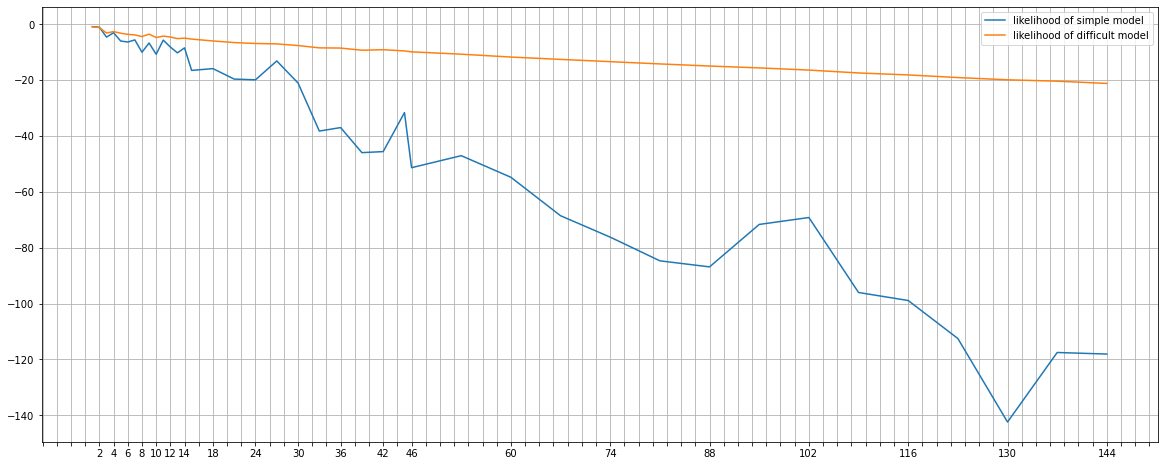

In [42]:

plt.figure(figsize = (20, 8))
ax = plt.gca()
simp = ax.plot(Ns, np.log(output_simple_010000[5, :]), label='likelihood of simple model')
diff = ax.plot(Ns, np.log(output_difficult_010000[5, :]), label = 'likelihood of difficult model')
plt.xticks(ticks = Ns, labels = Ns)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.xlabel('Number of datapoints')
plt.ylabel('mmLLH')
plt.grid()
plt.legend()
plt.show()

C:\Users\Hacker\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


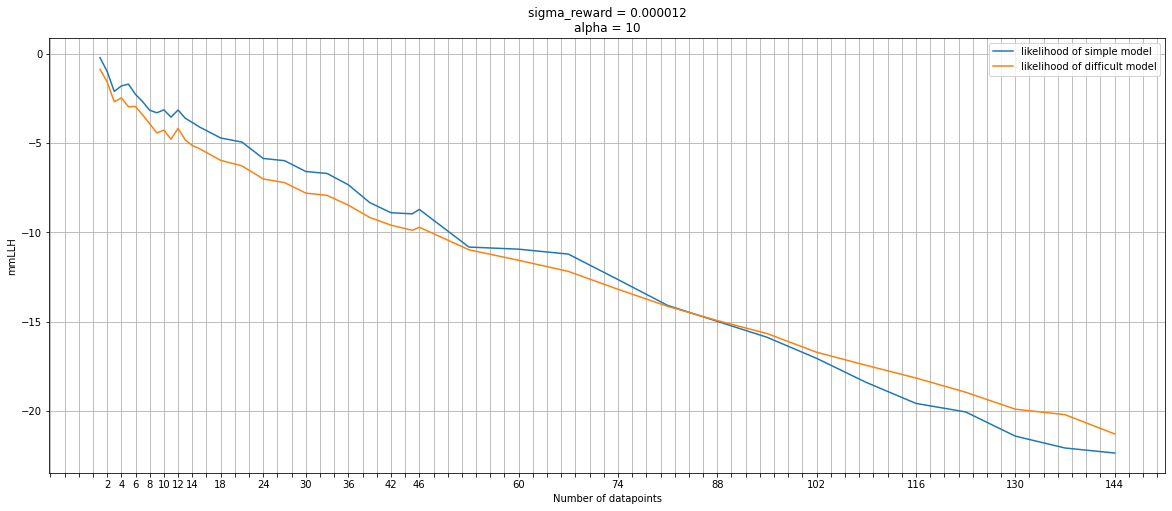

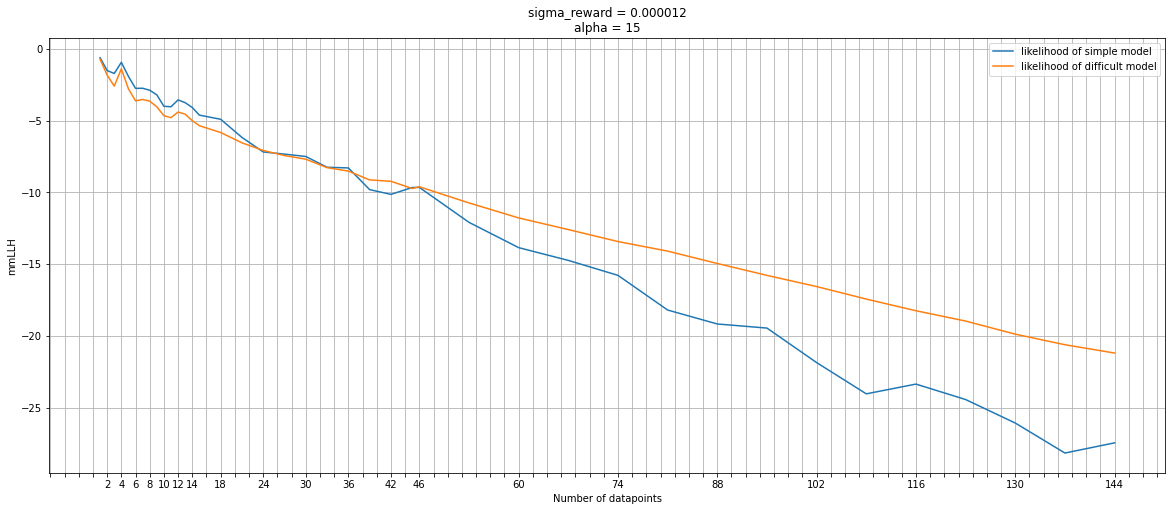

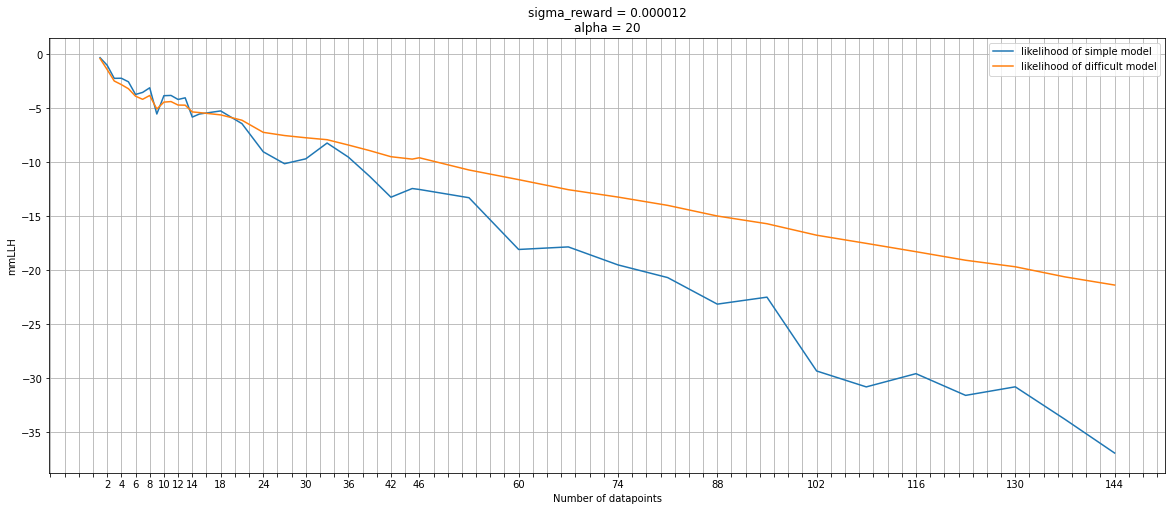

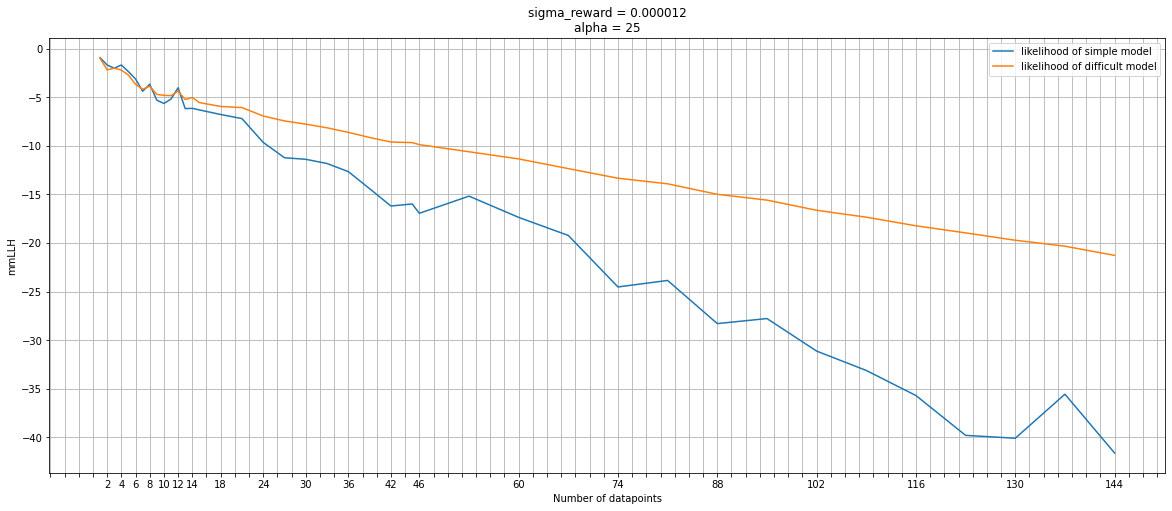

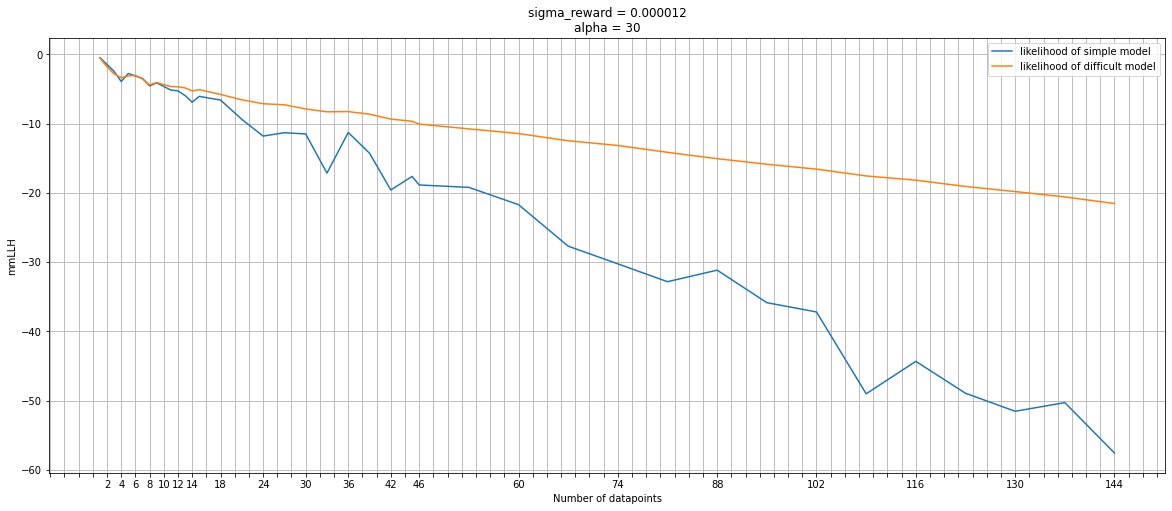

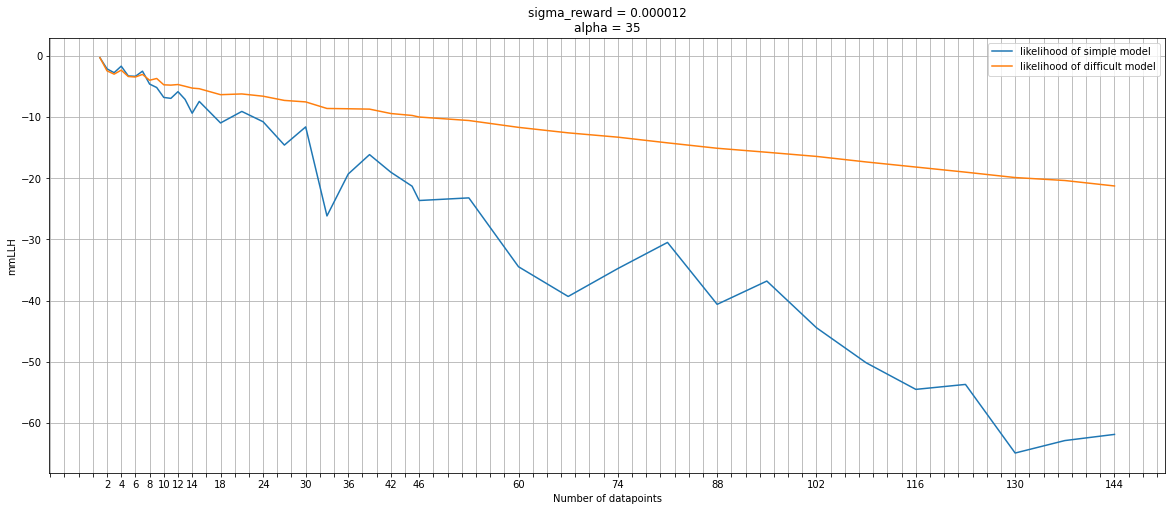

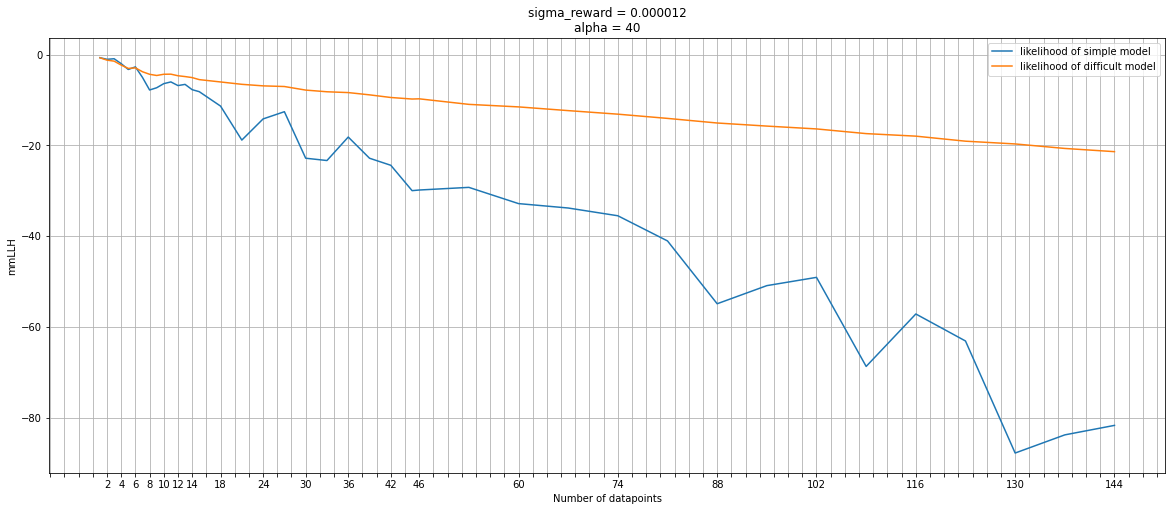

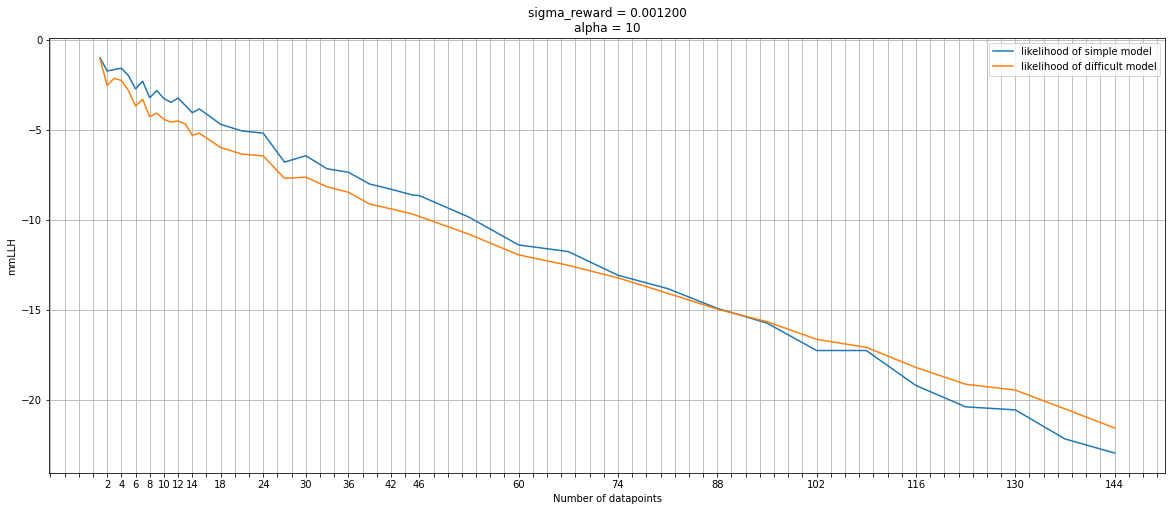

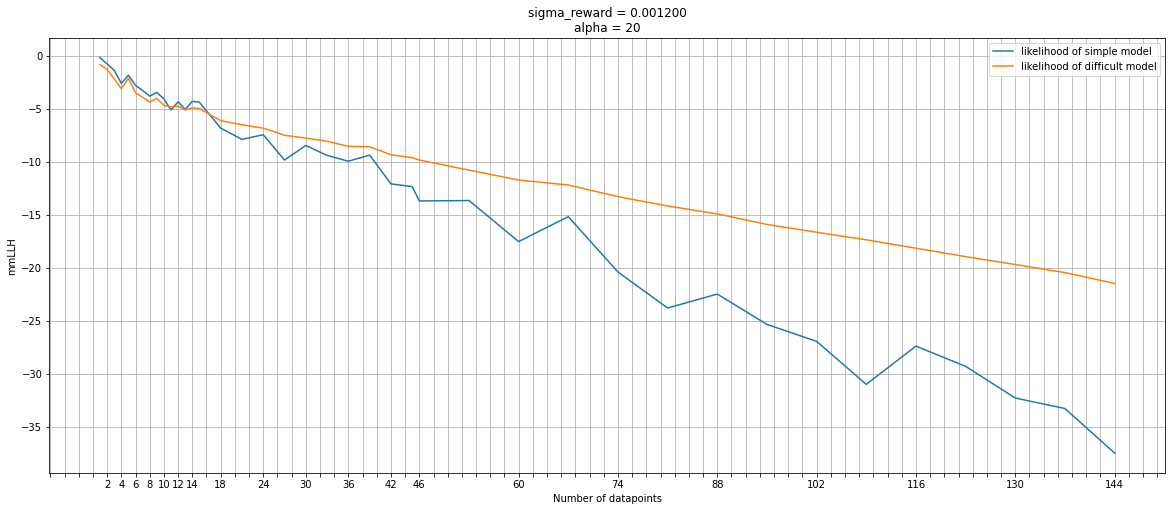

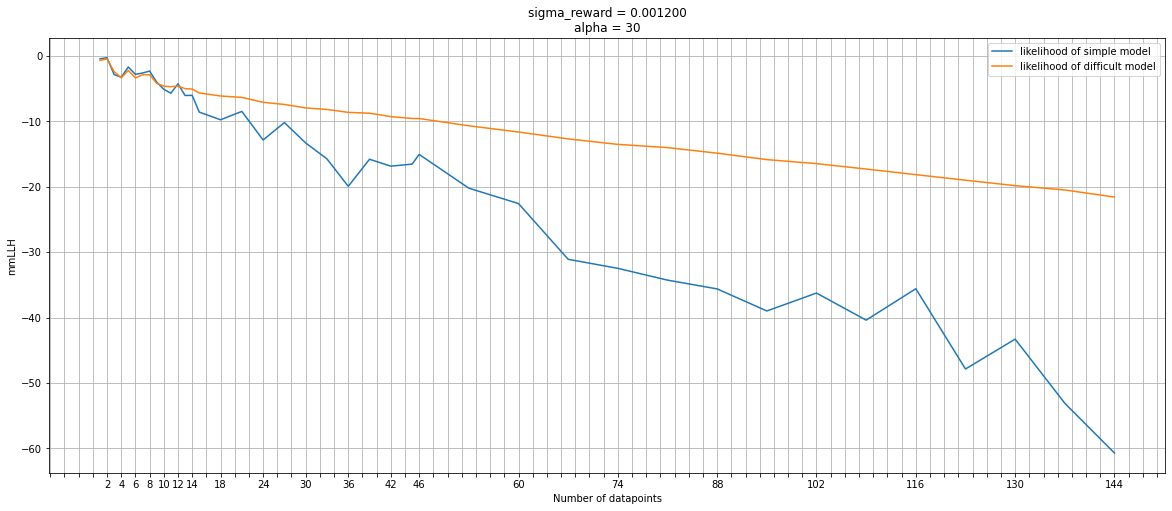

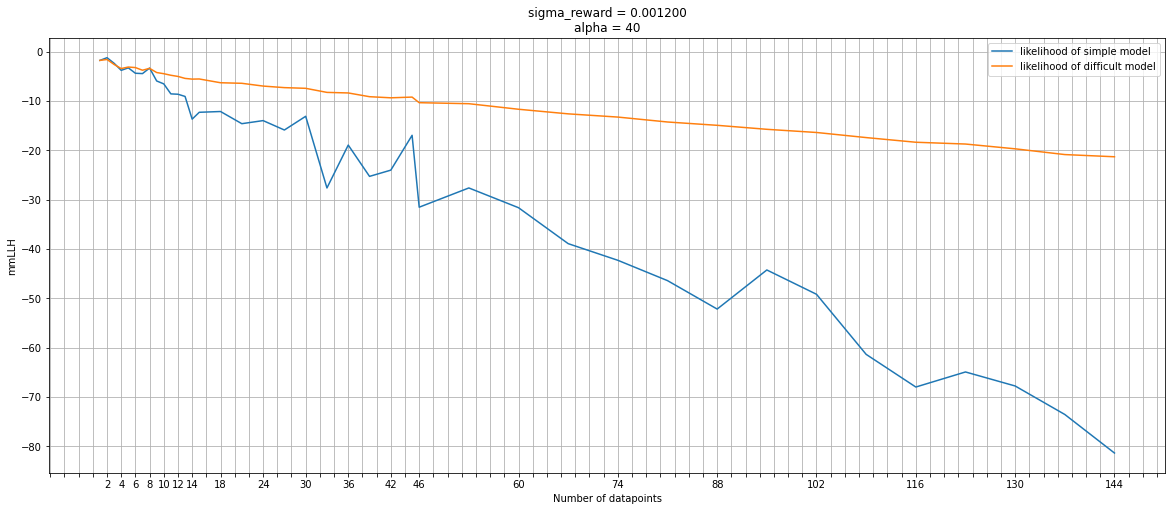

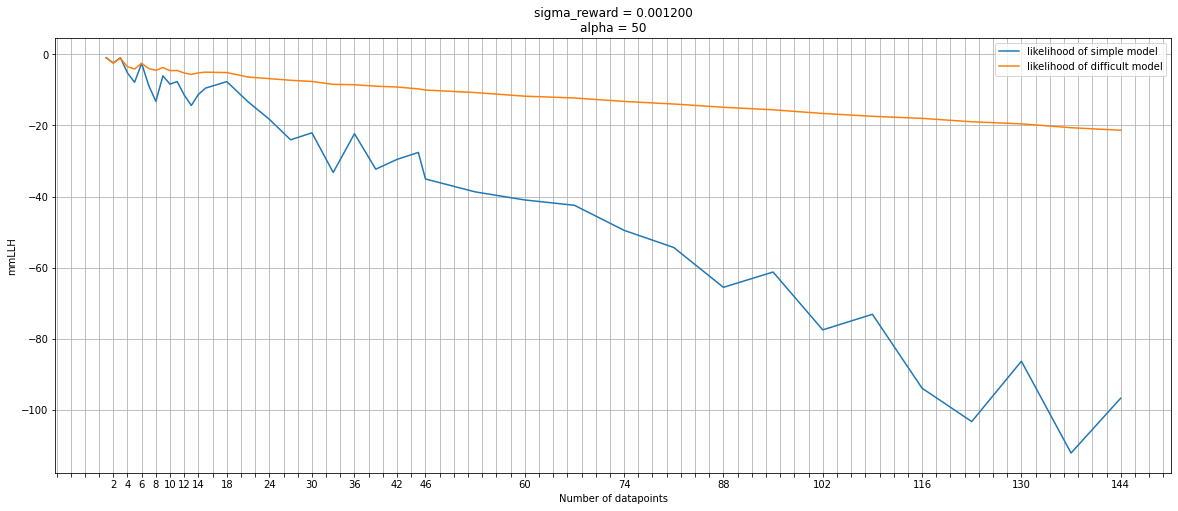

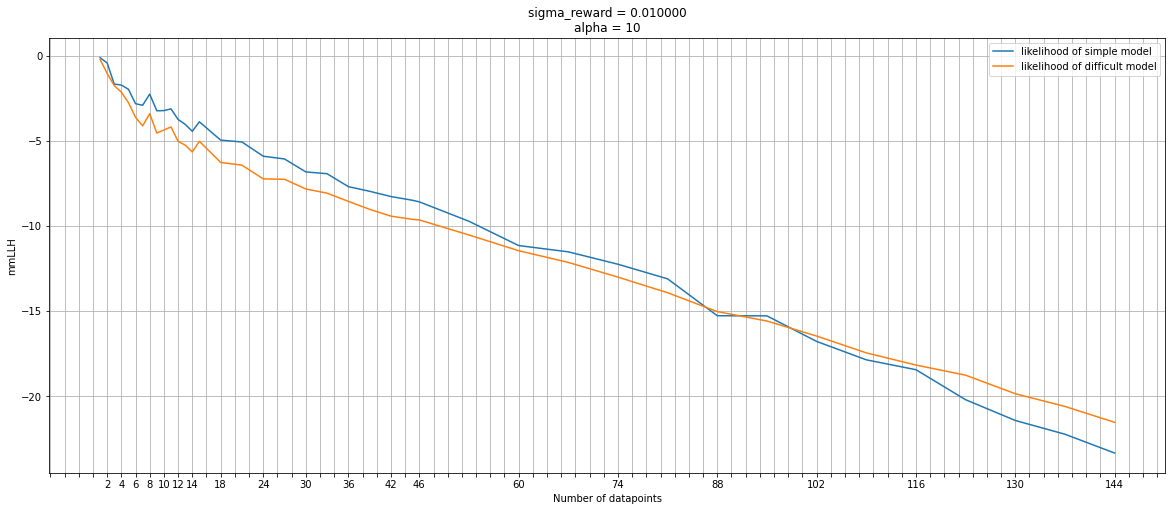

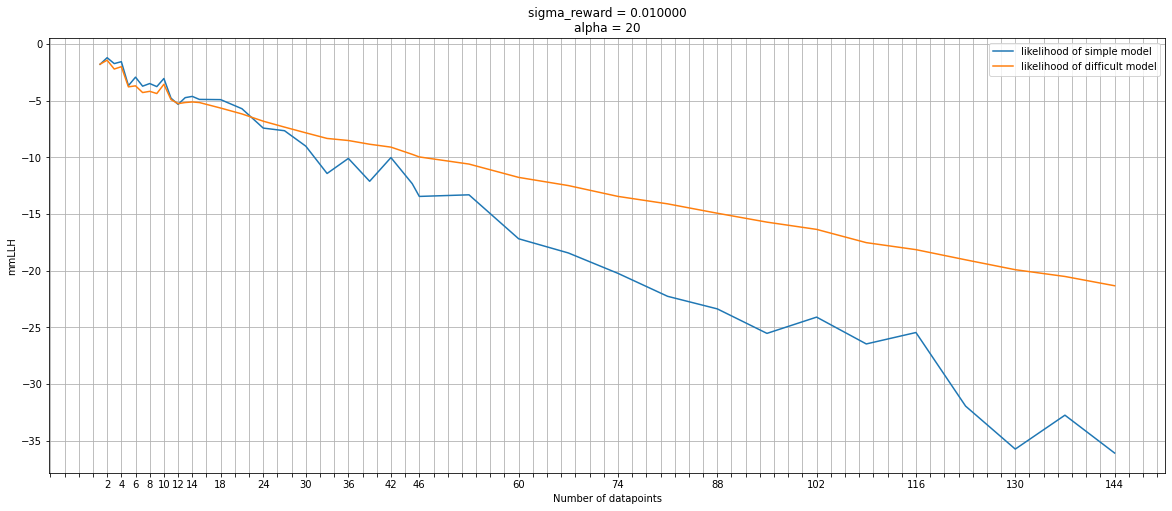

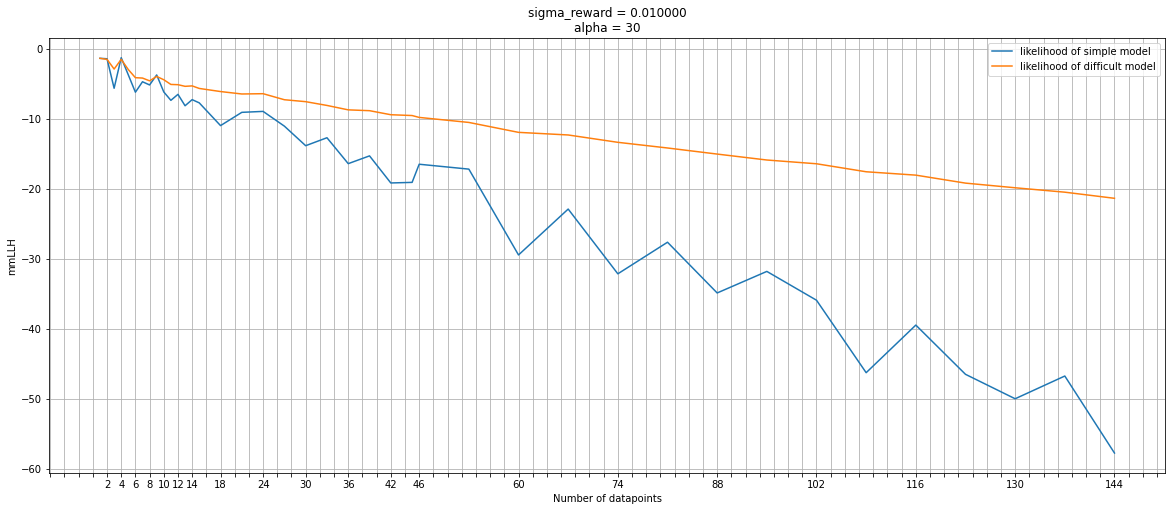

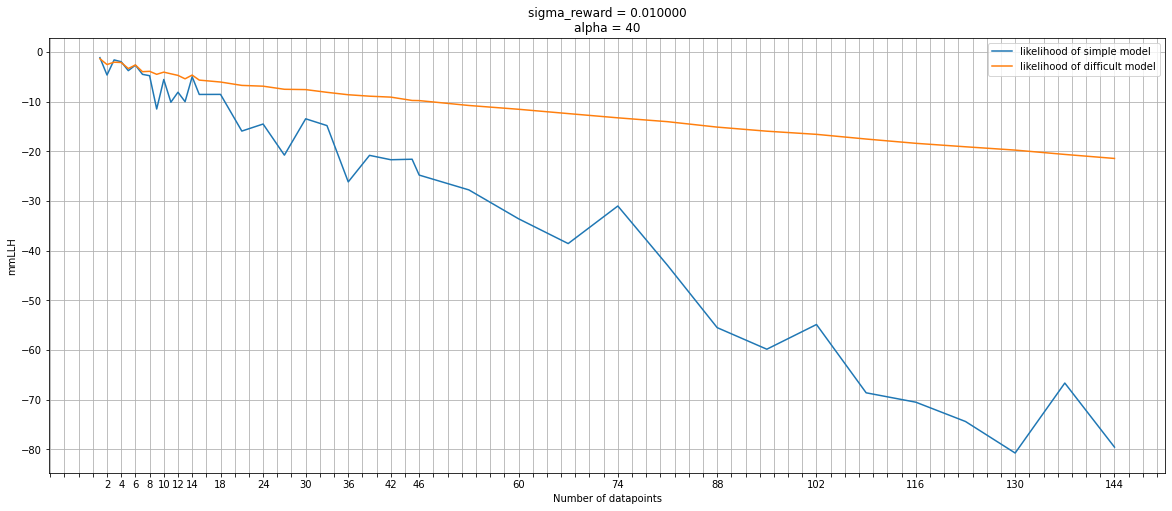

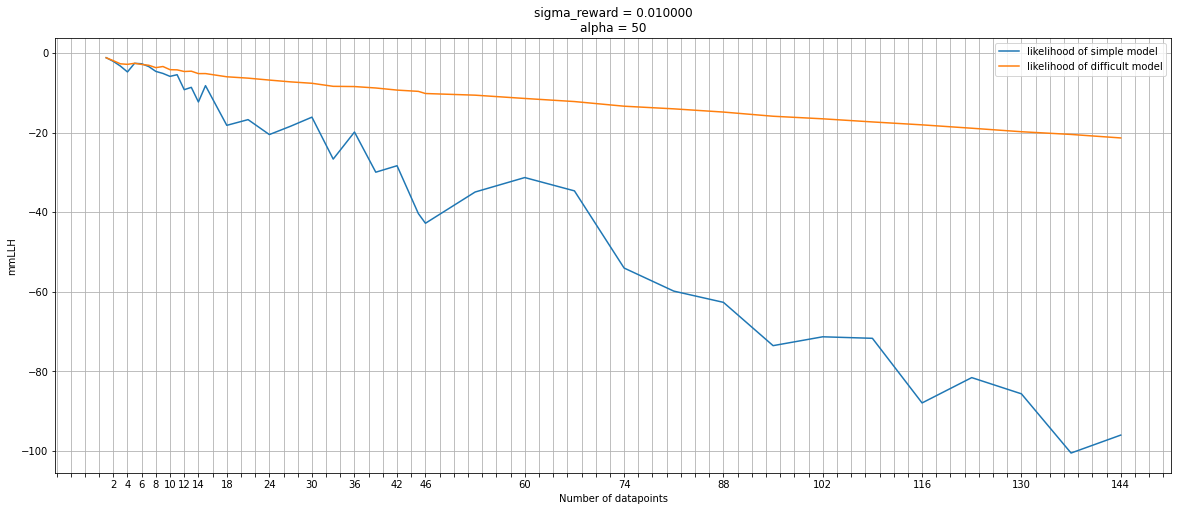

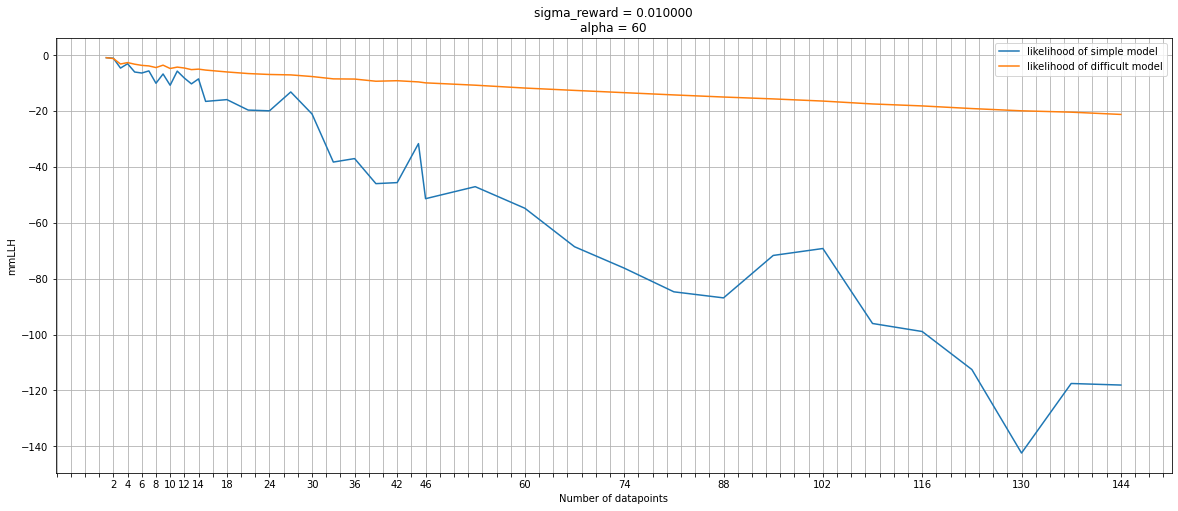

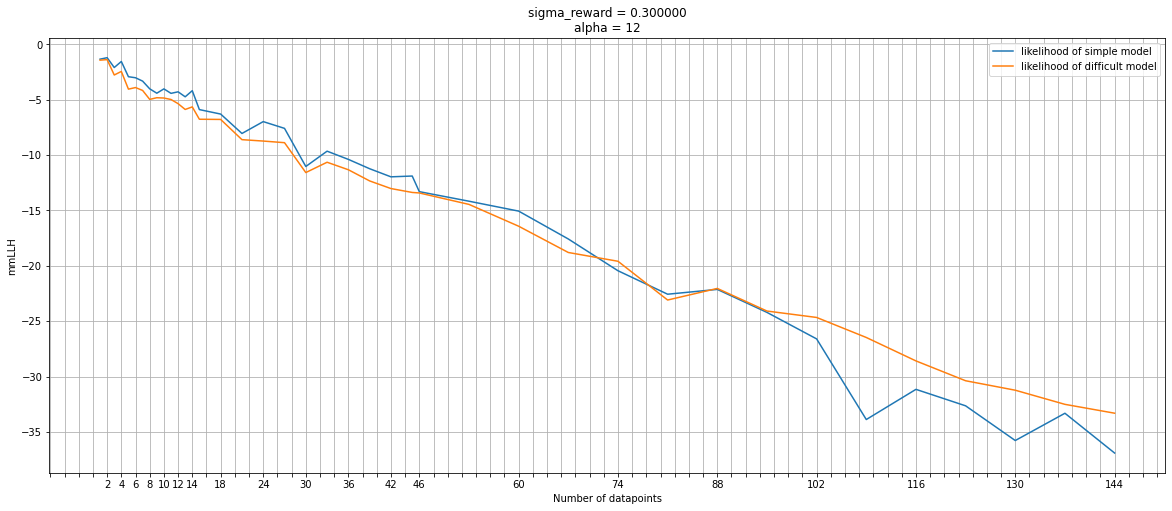

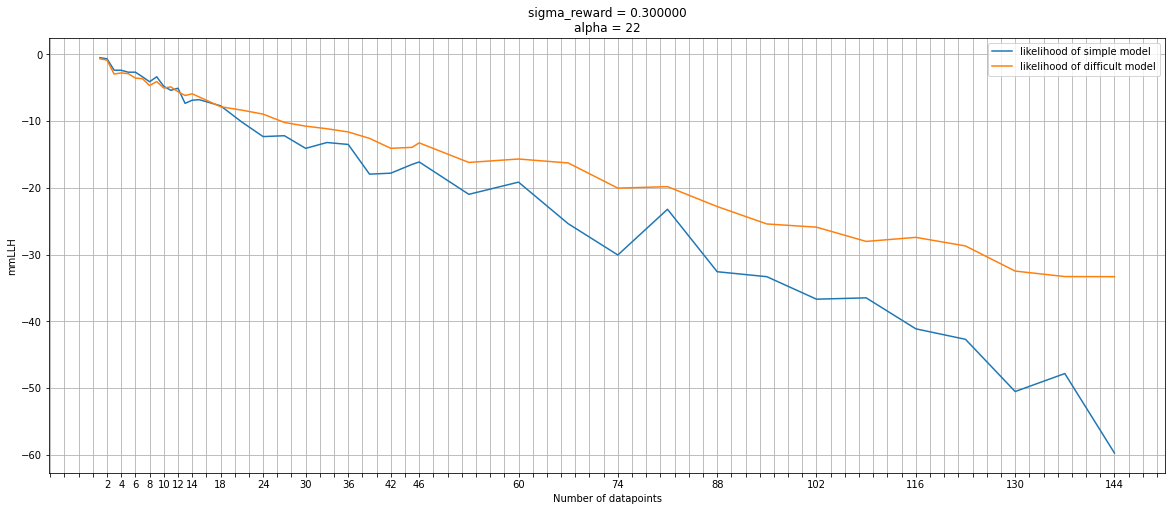

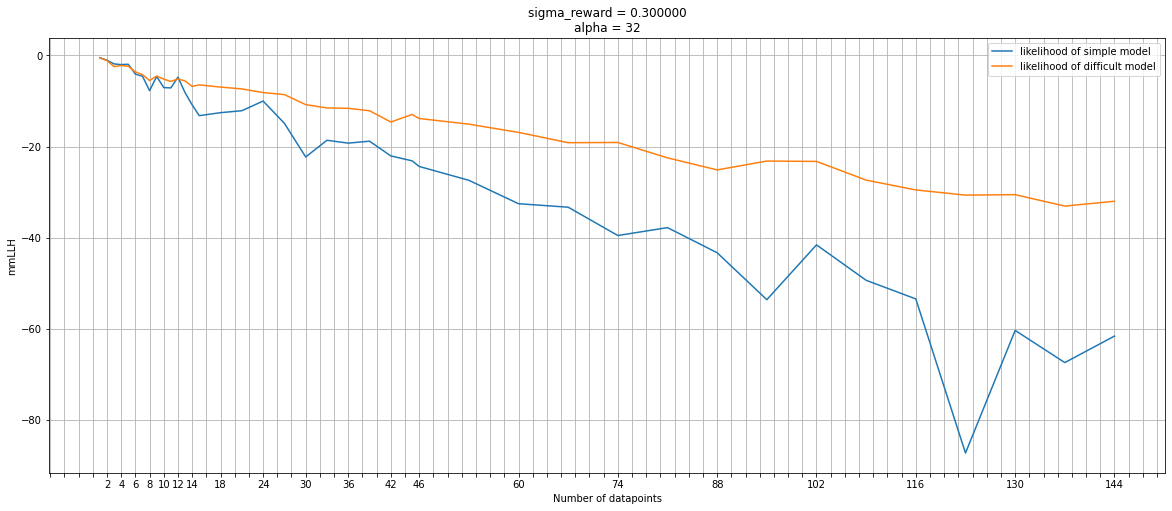

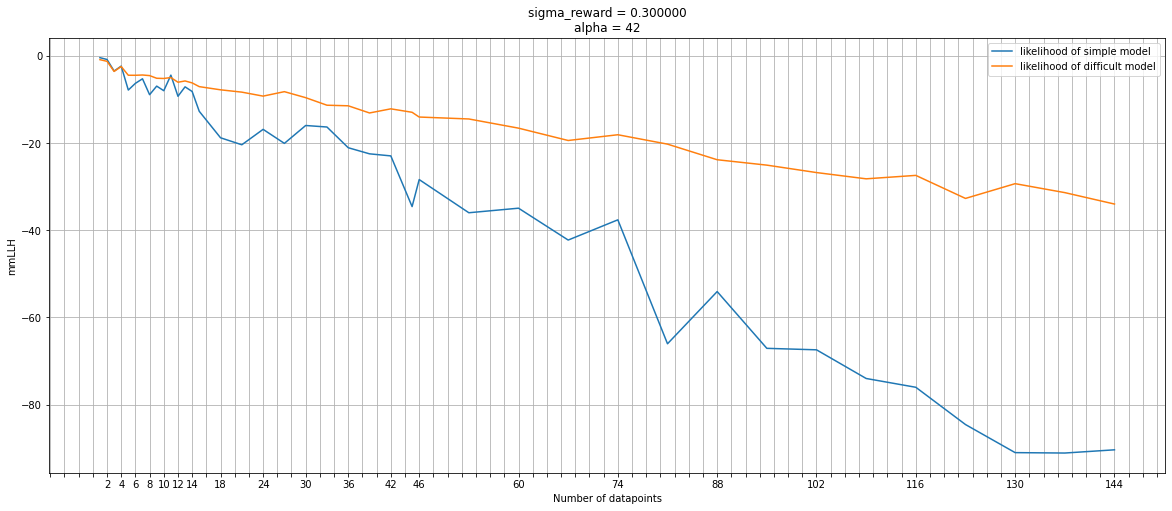

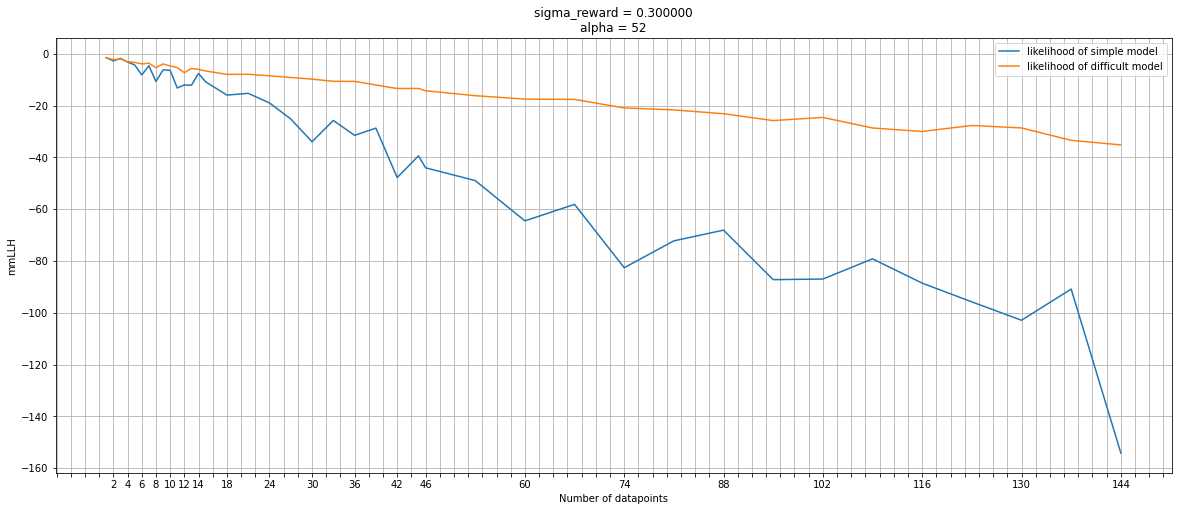

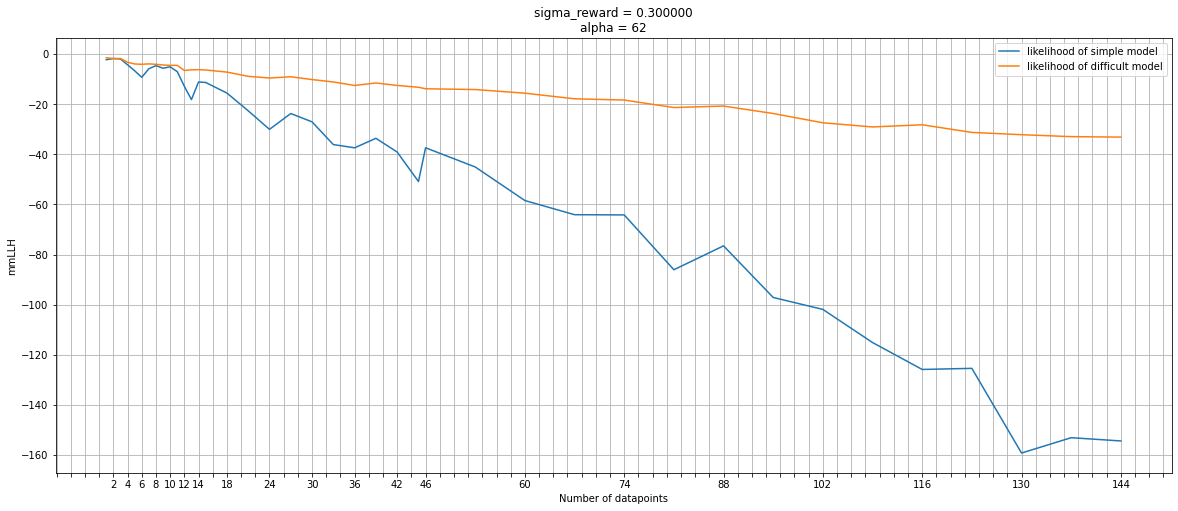

In [54]:
for sigma_reward in sigma_rewards:
    sigma = format(sigma_reward, 'f')
    exec('alphas = alphas_%s'%sigma.replace('0.', ''))
    for i, alpha in enumerate(alphas):
        plt.figure(figsize = (20, 8))
        ax = plt.gca()
        exec('simp = ax.plot(Ns, np.log(output_simple_%s[i, :]), label = "likelihood of simple model")'%sigma.replace('0.', ''))
        exec('diff = ax.plot(Ns, np.log(output_difficult_%s[i, :]), label = "likelihood of difficult model")'%sigma.replace('0.', ''))
        plt.xticks(ticks = Ns, labels = Ns)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.xlabel('Number of datapoints')
        plt.ylabel('mmLLH')
        plt.title('sigma_reward = %s\nalpha = %d'%(sigma, alpha))
        plt.grid()
        plt.legend()
        #plt.show()
        plt.savefig('./kepek/mmLLH_sigma_%s_alpha_%d.png'%(sigma, alpha))